# Predictive Stock Price Modeling Using LSTM, CNN, FCNN, and SVR Models

## Project Description:

### Objective:

The goal of this project is to develop and evaluate multiple machine learning models to predict stock prices based on historical data. By utilizing different deep learning architectures such as Long Short-Term Memory (LSTM), Convolutional Neural Networks (CNN), Fully Connected Neural Networks (FCNN), and Support Vector Regression (SVR), the project aims to compare their performance and identify the most effective approach for time series forecasting in the financial domain.

### Description:

Stock price prediction has always been a challenging yet rewarding task in the financial world. This project is centered around exploring how different machine learning models can forecast stock prices by learning patterns from past data. Four models are utilized—LSTM, CNN, FCNN, and SVR—to capture both short-term and long-term dependencies in stock price movements.

Each model is trained on historical stock data and evaluated using root mean squared error (RMSE) on both training and testing sets. The project explores the predictive power of these models, using a standard dataset of stock prices scaled for better model performance.

### The project includes:

*   Data preprocessing and scaling to prepare stock price data.
*   Training LSTM, CNN, FCNN, and SVR models for stock price prediction.
*   Evaluating the models based on RMSE metrics for both training and test sets.
*   Visualizing the actual vs. predicted stock prices to understand the performance of each model.


### Project Goals:

*   To effectively preprocess and scale stock price data for model input.
*   To train and fine-tune four different machine learning models (LSTM, CNN, FCNN, SVR) to capture price trends.
*   To compare and analyze the performance of these models using RMSE.
*   To visualize model predictions and actual stock prices for better interpretability.


### Data Preprocessing

In [5]:
# Import Required Libraries
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

# Load the Data
drive.mount('/content/drive')
filepath = '/content/drive/My Drive/Microsoft Projeleri 2024/Microsoft ML Internship/MSFT.csv'
data = pd.read_csv(filepath)
data = data.sort_values('Date')

# Display the First 5 Rows of the Data
print(data.head())

# Check for Missing Values in the Data
print(data.isnull().sum())

# Separate Features and Target Value
price = data[['Close']]

# Scale the Data
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1, 1))

# Split the Data into Training and Test Sets
def split_data(stock, lookback):
    data_raw = stock.to_numpy()  # Convert to Numpy array
    data = []

    # Create all possible sequences of length lookback
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]

    return [x_train, y_train, x_test, y_test]

lookback = 20  # Sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

# Convert Data to PyTorch Tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
         Date       Open       High        Low      Close  Adj Close    Volume
0  2015-07-06  43.959999  44.480000  43.950001  44.389999  38.785259  23034000
1  2015-07-07  44.340000  44.490002  43.320000  44.299999  38.706612  36435800
2  2015-07-08  44.439999  44.900002  44.029999  44.240002  38.654202  39785900
3  2015-07-09  44.750000  45.220001  44.500000  44.520000  38.898827  32424700
4  2015-07-10  45.009998  45.139999  44.570000  44.610001  38.977486  25465800
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
x_train.shape =  (1796, 19, 1)
y_train.shape =  (1796, 1)
x_test.shape =  (449, 19, 1)
y_test.shape =  (449, 1)


<ipython-input-5-2faff308a59b>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1, 1))


### 1. Deep LSTM Model Development

In [6]:
# Model Definition: Deeper LSTM
class DeepLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(DeepLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# Model Parameters
input_dim = 1
hidden_dim = 64
num_layers = 4
output_dim = 1
num_epochs = 100

# Model Initialization: Deep LSTM
model_lstm = DeepLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model_lstm.parameters(), lr=0.01)


In [7]:
# Train the LSTM Model
hist_lstm = np.zeros(num_epochs)
for t in range(num_epochs):
    model_lstm.train()
    y_train_pred = model_lstm(x_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "LSTM MSE: ", loss.item())
    hist_lstm[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch  0 LSTM MSE:  0.4408116340637207
Epoch  1 LSTM MSE:  0.20803417265415192
Epoch  2 LSTM MSE:  1.0462344884872437
Epoch  3 LSTM MSE:  0.16464930772781372
Epoch  4 LSTM MSE:  0.21660266816616058
Epoch  5 LSTM MSE:  0.24233980476856232
Epoch  6 LSTM MSE:  0.24666684865951538
Epoch  7 LSTM MSE:  0.2408140003681183
Epoch  8 LSTM MSE:  0.2292470932006836
Epoch  9 LSTM MSE:  0.21385861933231354
Epoch  10 LSTM MSE:  0.19591256976127625
Epoch  11 LSTM MSE:  0.17745329439640045
Epoch  12 LSTM MSE:  0.1627611219882965
Epoch  13 LSTM MSE:  0.15659476816654205
Epoch  14 LSTM MSE:  0.1423182189464569
Epoch  15 LSTM MSE:  0.08490728586912155
Epoch  16 LSTM MSE:  0.023976851254701614
Epoch  17 LSTM MSE:  0.044722892343997955
Epoch  18 LSTM MSE:  0.048582661896944046
Epoch  19 LSTM MSE:  0.045241013169288635
Epoch  20 LSTM MSE:  0.034014854580163956
Epoch  21 LSTM MSE:  0.030560920014977455
Epoch  22 LSTM MSE:  0.03406296670436859
Epoch  23 LSTM MSE:  0.037481583654880524
Epoch  24 LSTM MSE:  0.03

### 2. CNN Model Development

In [8]:
# Model Definition: CNN
class CNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch_size, input_dim, seq_len)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.mean(dim=2)  # Global average pooling
        x = self.fc(x)
        return x

# Model Initialization: CNN
model_cnn = CNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model_cnn.parameters(), lr=0.01)

In [9]:
# Train the CNN Model
hist_cnn = np.zeros(num_epochs)
for t in range(num_epochs):
    model_cnn.train()
    y_train_pred = model_cnn(x_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "CNN MSE: ", loss.item())
    hist_cnn[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch  0 CNN MSE:  0.40556302666664124
Epoch  1 CNN MSE:  0.06796527653932571
Epoch  2 CNN MSE:  0.0678897425532341
Epoch  3 CNN MSE:  0.011185485869646072
Epoch  4 CNN MSE:  0.021622348576784134
Epoch  5 CNN MSE:  0.020405299961566925
Epoch  6 CNN MSE:  0.004445984028279781
Epoch  7 CNN MSE:  0.011386374942958355
Epoch  8 CNN MSE:  0.018341993913054466
Epoch  9 CNN MSE:  0.01033827755600214
Epoch  10 CNN MSE:  0.0038778972811996937
Epoch  11 CNN MSE:  0.0067169517278671265
Epoch  12 CNN MSE:  0.009944022633135319
Epoch  13 CNN MSE:  0.00751549331471324
Epoch  14 CNN MSE:  0.0032165811862796545
Epoch  15 CNN MSE:  0.0026462210807949305
Epoch  16 CNN MSE:  0.005588612053543329
Epoch  17 CNN MSE:  0.007087233942002058
Epoch  18 CNN MSE:  0.005267319735139608
Epoch  19 CNN MSE:  0.0032391492277383804
Epoch  20 CNN MSE:  0.0034887560177594423
Epoch  21 CNN MSE:  0.004790297709405422
Epoch  22 CNN MSE:  0.0047436966560781
Epoch  23 CNN MSE:  0.003083286341279745
Epoch  24 CNN MSE:  0.001698

### 3. FCNN Model Development

In [10]:
# Model Definition: FCNN
class FCNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model Initialization: FCNN
model_fcnn = FCNN(input_dim=19, hidden_dim=hidden_dim, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model_fcnn.parameters(), lr=0.01)


In [11]:
# Train the FCNN Model
hist_fcnn = np.zeros(num_epochs)
for t in range(num_epochs):
    model_fcnn.train()
    y_train_pred = model_fcnn(x_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "FCNN MSE: ", loss.item())
    hist_fcnn[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch  0 FCNN MSE:  0.2461370974779129
Epoch  1 FCNN MSE:  0.02471974678337574
Epoch  2 FCNN MSE:  0.09582874178886414
Epoch  3 FCNN MSE:  0.02300691232085228
Epoch  4 FCNN MSE:  0.018563978374004364
Epoch  5 FCNN MSE:  0.04602630063891411
Epoch  6 FCNN MSE:  0.03470480814576149
Epoch  7 FCNN MSE:  0.011384192854166031
Epoch  8 FCNN MSE:  0.003634001826867461
Epoch  9 FCNN MSE:  0.014189278706908226
Epoch  10 FCNN MSE:  0.0159489493817091
Epoch  11 FCNN MSE:  0.00474946154281497
Epoch  12 FCNN MSE:  0.010230964049696922
Epoch  13 FCNN MSE:  0.011067596264183521
Epoch  14 FCNN MSE:  0.0029807647224515676
Epoch  15 FCNN MSE:  0.0035154770594090223
Epoch  16 FCNN MSE:  0.0060094925574958324
Epoch  17 FCNN MSE:  0.004398399963974953
Epoch  18 FCNN MSE:  0.0021829335018992424
Epoch  19 FCNN MSE:  0.0032541851978749037
Epoch  20 FCNN MSE:  0.005136680323630571
Epoch  21 FCNN MSE:  0.004426339641213417
Epoch  22 FCNN MSE:  0.0024331165477633476
Epoch  23 FCNN MSE:  0.002147925551980734
Epoch 

### 4. SVR Model Development

In [14]:
import math
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Reshaping data for SVR
x_train_svr = x_train.numpy().reshape(x_train.shape[0], -1)
x_test_svr = x_test.numpy().reshape(x_test.shape[0], -1)
y_train_svr = y_train.numpy().ravel()
y_test_svr = y_test.numpy().ravel()

# Defining the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 'scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.5, 0.3]
}

# Finding the best hyperparameters using GridSearchCV
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train_svr, y_train_svr)

print("Best hyperparameters: ", grid_search.best_params_)

# Retraining the model with the best hyperparameters
best_svr_model = grid_search.best_estimator_
best_svr_model.fit(x_train_svr, y_train_svr)

# Making predictions
y_train_pred_svr = best_svr_model.predict(x_train_svr)
y_test_pred_svr = best_svr_model.predict(x_test_svr)

# Inverse scaling the predictions
y_train_pred_svr = scaler.inverse_transform(y_train_pred_svr.reshape(-1, 1))
y_test_pred_svr = scaler.inverse_transform(y_test_pred_svr.reshape(-1, 1))
y_train_svr = scaler.inverse_transform(y_train_svr.reshape(-1, 1))
y_test_svr = scaler.inverse_transform(y_test_svr.reshape(-1, 1))

# Calculating RMSE
train_rmse_svr = math.sqrt(mean_squared_error(y_train_svr, y_train_pred_svr))
test_rmse_svr = math.sqrt(mean_squared_error(y_test_svr, y_test_pred_svr))

print(f'SVR Train RMSE: {train_rmse_svr}')
print(f'SVR Test RMSE: {test_rmse_svr}')


Best hyperparameters:  {'C': 100, 'epsilon': 0.1, 'gamma': 0.001}
SVR Train RMSE: 7.543635114546614
SVR Test RMSE: 9.667885116572904


### Performance Evaluation & Visualization

LSTM Train RMSE: 6.342592932501807
LSTM Test RMSE: 25.866511477499724
CNN Train RMSE: 6.751058707392071
CNN Test RMSE: 13.395976222548251
FCNN Train RMSE: 5.070276386620235
FCNN Test RMSE: 11.051033240985179
SVR Train RMSE: 7.543635114546614
SVR Test RMSE: 9.667885116572904


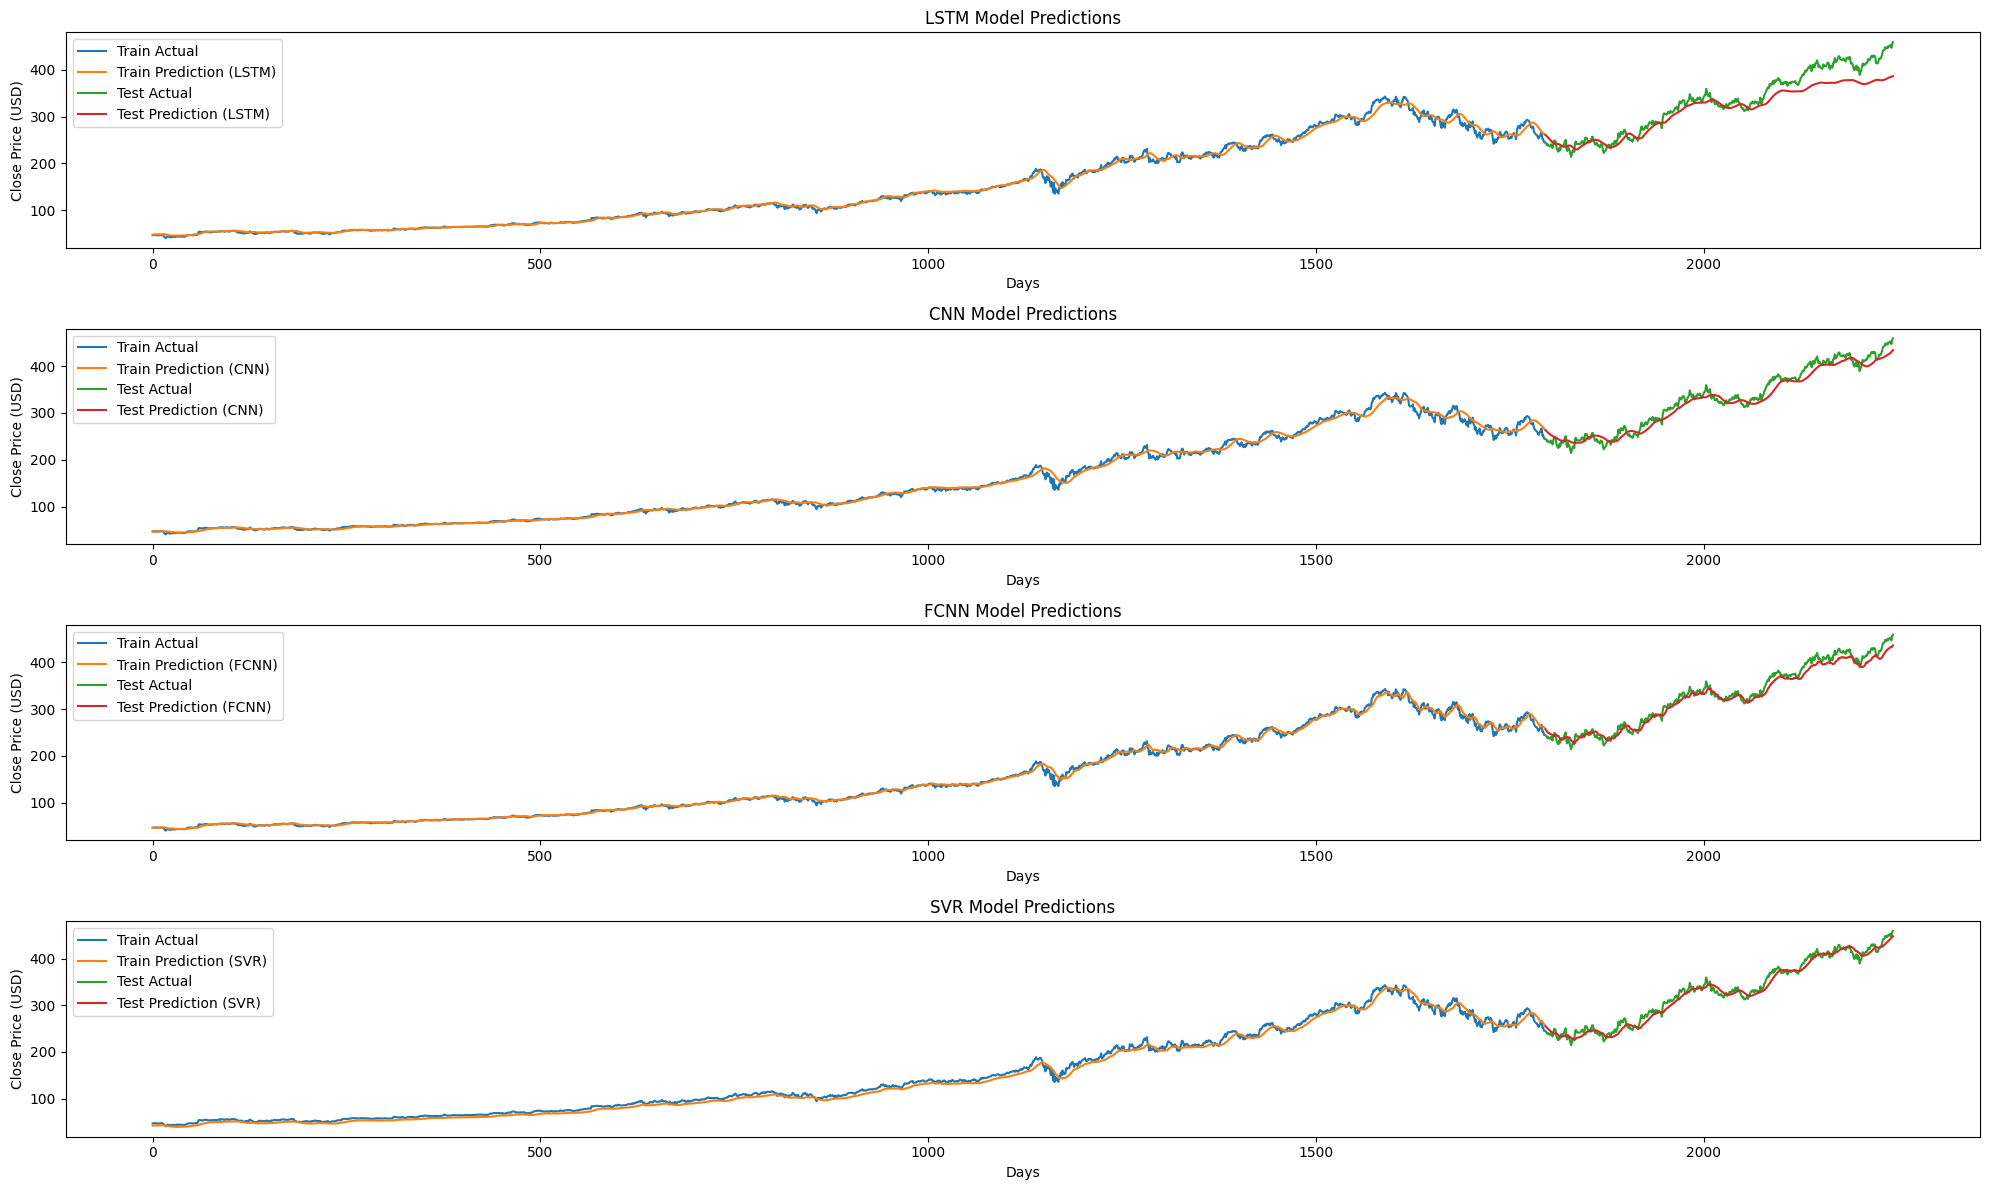

In [15]:
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

# Making predictions for the LSTM model
model_lstm.eval()
y_train_pred_lstm = model_lstm(x_train).detach().numpy()
y_test_pred_lstm = model_lstm(x_test).detach().numpy()

# Making predictions for the CNN model
model_cnn.eval()
y_train_pred_cnn = model_cnn(x_train).detach().numpy()
y_test_pred_cnn = model_cnn(x_test).detach().numpy()

# Making predictions for the FCNN model
model_fcnn.eval()
y_train_pred_fcnn = model_fcnn(x_train).detach().numpy()
y_test_pred_fcnn = model_fcnn(x_test).detach().numpy()

# Inverse scaling the predictions
y_train_pred_lstm = scaler.inverse_transform(y_train_pred_lstm)
y_test_pred_lstm = scaler.inverse_transform(y_test_pred_lstm)
y_train_lstm = scaler.inverse_transform(y_train.numpy())
y_test_lstm = scaler.inverse_transform(y_test.numpy())

y_train_pred_cnn = scaler.inverse_transform(y_train_pred_cnn)
y_test_pred_cnn = scaler.inverse_transform(y_test_pred_cnn)
y_train_cnn = scaler.inverse_transform(y_train.numpy())
y_test_cnn = scaler.inverse_transform(y_test.numpy())

y_train_pred_fcnn = scaler.inverse_transform(y_train_pred_fcnn)
y_test_pred_fcnn = scaler.inverse_transform(y_test_pred_fcnn)
y_train_fcnn = scaler.inverse_transform(y_train.numpy())
y_test_fcnn = scaler.inverse_transform(y_test.numpy())

# Calculating RMSE
train_rmse_lstm = math.sqrt(mean_squared_error(y_train_lstm, y_train_pred_lstm))
test_rmse_lstm = math.sqrt(mean_squared_error(y_test_lstm, y_test_pred_lstm))
train_rmse_cnn = math.sqrt(mean_squared_error(y_train_cnn, y_train_pred_cnn))
test_rmse_cnn = math.sqrt(mean_squared_error(y_test_cnn, y_test_pred_cnn))
train_rmse_fcnn = math.sqrt(mean_squared_error(y_train_fcnn, y_train_pred_fcnn))
test_rmse_fcnn = math.sqrt(mean_squared_error(y_test_fcnn, y_test_pred_fcnn))
train_rmse_svr = math.sqrt(mean_squared_error(y_train_svr, y_train_pred_svr))
test_rmse_svr = math.sqrt(mean_squared_error(y_test_svr, y_test_pred_svr))

print(f'LSTM Train RMSE: {train_rmse_lstm}')
print(f'LSTM Test RMSE: {test_rmse_lstm}')
print(f'CNN Train RMSE: {train_rmse_cnn}')
print(f'CNN Test RMSE: {test_rmse_cnn}')
print(f'FCNN Train RMSE: {train_rmse_fcnn}')
print(f'FCNN Test RMSE: {test_rmse_fcnn}')
print(f'SVR Train RMSE: {train_rmse_svr}')
print(f'SVR Test RMSE: {test_rmse_svr}')

# Visualizing the results
plt.figure(figsize=(20, 12))

# LSTM Predictions
plt.subplot(4, 1, 1)
plt.plot(y_train_lstm, label='Train Actual')
plt.plot(y_train_pred_lstm, label='Train Prediction (LSTM)')
plt.plot(range(len(y_train_lstm), len(y_train_lstm) + len(y_test_lstm)), y_test_lstm, label='Test Actual')
plt.plot(range(len(y_train_lstm), len(y_train_lstm) + len(y_test_lstm)), y_test_pred_lstm, label='Test Prediction (LSTM)')
plt.title("LSTM Model Predictions")
plt.xlabel("Days")
plt.ylabel("Close Price (USD)")
plt.legend()

# CNN Predictions
plt.subplot(4, 1, 2)
plt.plot(y_train_cnn, label='Train Actual')
plt.plot(y_train_pred_cnn, label='Train Prediction (CNN)')
plt.plot(range(len(y_train_cnn), len(y_train_cnn) + len(y_test_cnn)), y_test_cnn, label='Test Actual')
plt.plot(range(len(y_train_cnn), len(y_train_cnn) + len(y_test_cnn)), y_test_pred_cnn, label='Test Prediction (CNN)')
plt.title("CNN Model Predictions")
plt.xlabel("Days")
plt.ylabel("Close Price (USD)")
plt.legend()

# FCNN Predictions
plt.subplot(4, 1, 3)
plt.plot(y_train_fcnn, label='Train Actual')
plt.plot(y_train_pred_fcnn, label='Train Prediction (FCNN)')
plt.plot(range(len(y_train_fcnn), len(y_train_fcnn) + len(y_test_fcnn)), y_test_fcnn, label='Test Actual')
plt.plot(range(len(y_train_fcnn), len(y_train_fcnn) + len(y_test_fcnn)), y_test_pred_fcnn, label='Test Prediction (FCNN)')
plt.title("FCNN Model Predictions")
plt.xlabel("Days")
plt.ylabel("Close Price (USD)")
plt.legend()

# SVR Predictions
plt.subplot(4, 1, 4)
plt.plot(y_train_svr, label='Train Actual')
plt.plot(y_train_pred_svr, label='Train Prediction (SVR)')
plt.plot(range(len(y_train_svr), len(y_train_svr) + len(y_test_svr)), y_test_svr, label='Test Actual')
plt.plot(range(len(y_train_svr), len(y_train_svr) + len(y_test_svr)), y_test_pred_svr, label='Test Prediction (SVR)')
plt.title("SVR Model Predictions")
plt.xlabel("Days")
plt.ylabel("Close Price (USD)")
plt.legend()

plt.tight_layout()
plt.show()


### Results Saving

  Model  Train RMSE  Test RMSE
0  LSTM    6.342593  25.866511
1   CNN    6.751059  13.395976
2  FCNN    5.070276  11.051033
3   SVR    7.543635   9.667885


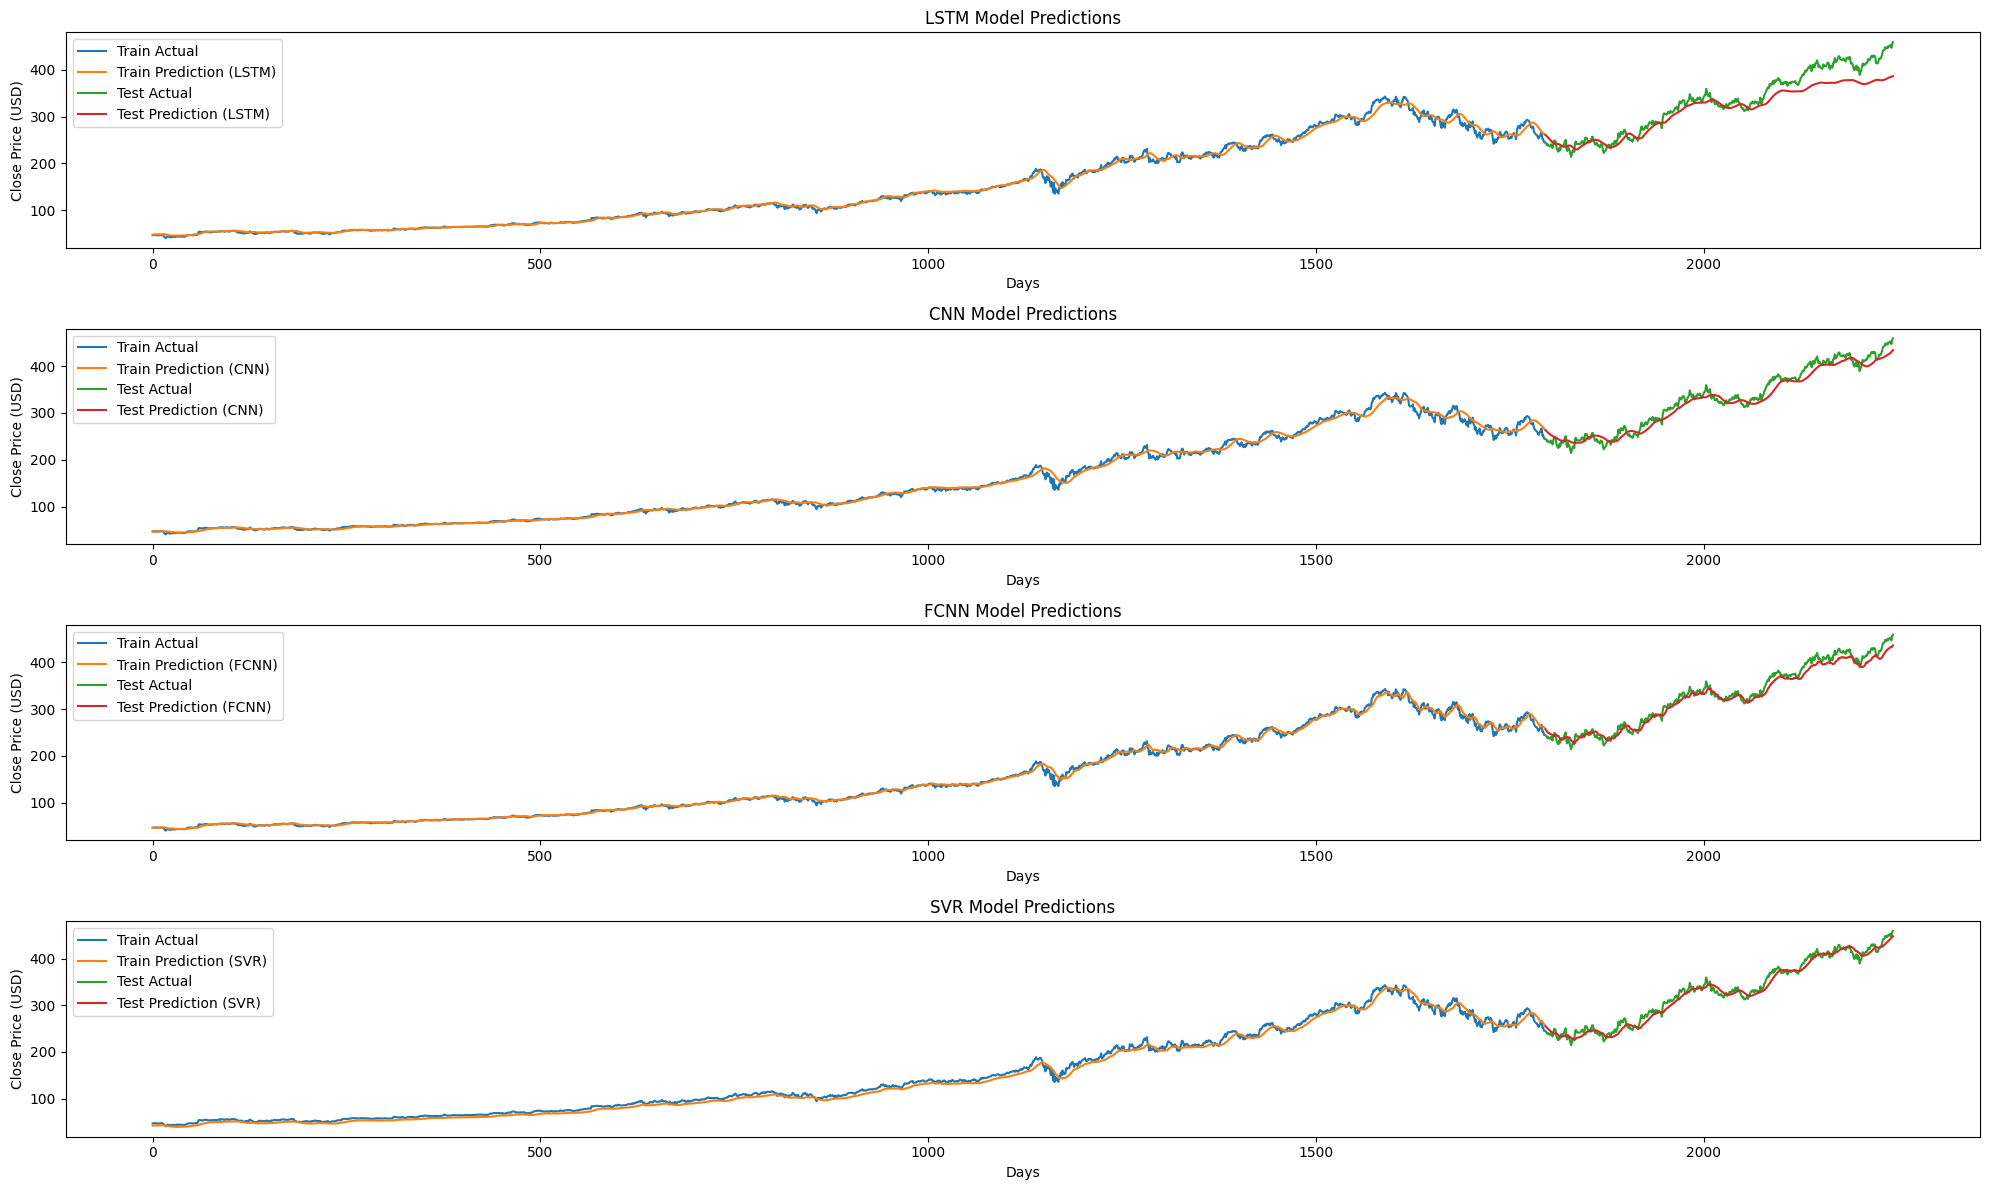

In [18]:
# Saving the results as a DataFrame
results = {
    'Model': ['LSTM', 'CNN', 'FCNN', 'SVR'],
    'Train RMSE': [train_rmse_lstm, train_rmse_cnn, train_rmse_fcnn, train_rmse_svr],
    'Test RMSE': [test_rmse_lstm, test_rmse_cnn, test_rmse_fcnn, test_rmse_svr]
}

results_df = pd.DataFrame(results)
results_df.to_csv('/content/drive/My Drive/Microsoft Projeleri 2024/Microsoft ML Internship/model_results.csv', index=False)
print(results_df)

# Saving the graph
plt.figure(figsize=(20, 12))

# LSTM Predictions
plt.subplot(4, 1, 1)
plt.plot(y_train_lstm, label='Train Actual')
plt.plot(y_train_pred_lstm, label='Train Prediction (LSTM)')
plt.plot(range(len(y_train_lstm), len(y_train_lstm) + len(y_test_lstm)), y_test_lstm, label='Test Actual')
plt.plot(range(len(y_train_lstm), len(y_train_lstm) + len(y_test_lstm)), y_test_pred_lstm, label='Test Prediction (LSTM)')
plt.title("LSTM Model Predictions")
plt.xlabel("Days")
plt.ylabel("Close Price (USD)")
plt.legend()

# CNN Predictions
plt.subplot(4, 1, 2)
plt.plot(y_train_cnn, label='Train Actual')
plt.plot(y_train_pred_cnn, label='Train Prediction (CNN)')
plt.plot(range(len(y_train_cnn), len(y_train_cnn) + len(y_test_cnn)), y_test_cnn, label='Test Actual')
plt.plot(range(len(y_train_cnn), len(y_train_cnn) + len(y_test_cnn)), y_test_pred_cnn, label='Test Prediction (CNN)')
plt.title("CNN Model Predictions")
plt.xlabel("Days")
plt.ylabel("Close Price (USD)")
plt.legend()

# FCNN Predictions
plt.subplot(4, 1, 3)
plt.plot(y_train_fcnn, label='Train Actual')
plt.plot(y_train_pred_fcnn, label='Train Prediction (FCNN)')
plt.plot(range(len(y_train_fcnn), len(y_train_fcnn) + len(y_test_fcnn)), y_test_fcnn, label='Test Actual')
plt.plot(range(len(y_train_fcnn), len(y_train_fcnn) + len(y_test_fcnn)), y_test_pred_fcnn, label='Test Prediction (FCNN)')
plt.title("FCNN Model Predictions")
plt.xlabel("Days")
plt.ylabel("Close Price (USD)")
plt.legend()

# SVR Predictions
plt.subplot(4, 1, 4)
plt.plot(y_train_svr, label='Train Actual')
plt.plot(y_train_pred_svr, label='Train Prediction (SVR)')
plt.plot(range(len(y_train_svr), len(y_train_svr) + len(y_test_svr)), y_test_svr, label='Test Actual')
plt.plot(range(len(y_train_svr), len(y_train_svr) + len(y_test_svr)), y_test_pred_svr, label='Test Prediction (SVR)')
plt.title("SVR Model Predictions")
plt.xlabel("Days")
plt.ylabel("Close Price (USD)")
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/My Drive/Microsoft Projeleri 2024/Microsoft ML Internship/model_predictions.png')
plt.show()


### Conclusion:

In this project, we explored various machine learning models—LSTM, CNN, FCNN, and SVR—to predict stock prices based on historical data. The results highlight the strengths and weaknesses of each model in time series forecasting. The LSTM model, designed to capture long-term dependencies, provided competitive results, while the CNN and FCNN models demonstrated their ability to learn patterns in the data effectively. The SVR model also offered a more traditional approach to regression-based forecasting.

By comparing these models, we can gain valuable insights into their predictive capabilities, helping to make informed decisions when selecting a model for stock price prediction tasks. This project serves as a foundation for further tuning and expanding model architectures or adding more complex features for improved accuracy.

In future iterations, we can incorporate additional features such as technical indicators, sentiment analysis, or macroeconomic factors to enhance prediction accuracy. Moreover, exploring more advanced deep learning techniques or ensemble models could yield even more robust results.